## Topic Modelling

In [38]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [39]:
import sys
import os
#!{sys.executable} -m spacy download en
import re, numpy as np, pandas as pd
from pprint import pprint

# Gensim
import gensim, spacy, logging, warnings
import gensim.corpora as corpora
import gensim.utils
from gensim.models import CoherenceModel
import matplotlib.pyplot as plt

# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use', 'not', 'would', 'say', 'could', '_', 'be', 'know', 'good', 'go', 'get', 'do', 'done', 'try', 'many', 'some', 'nice', 'thank', 'think', 'see', 'rather', 'easy', 'easily', 'lot', 'lack', 'make', 'want', 'seem', 'run', 'need', 'even', 'right', 'line', 'even', 'also', 'may', 'take', 'come'])

%matplotlib inline
warnings.filterwarnings("ignore",category=DeprecationWarning)
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

In [40]:
### from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use', 'could', 'also'])

## Loading data

In [44]:
df = pd.read_csv('data/courses.csv')
df = df.fillna("")
df.columns

Index(['ID', 'Country', 'Univeristy', 'G2RWorldRank', 'G2RNationalRank',
       'QSWorldUniversityRanking2021', 'Program',
       'SchoolOfferingCourseProgram', 'CourseDescription', 'Course Unit',
       'CourseUnitGoals', 'CourseUnitOutcomes'],
      dtype='object')

In [45]:
df ['summary'] = df['CourseDescription'] + df['CourseUnitGoals'] + df['CourseUnitOutcomes']
data = list(df['summary'])
len(data)

503

## Tokenizing and cleaning data

In [46]:
from gensim.utils import simple_preprocess
def clean_text(texts):
    for sent in texts:
        sent = re.sub('\S*@\S*\s?', '', sent)  # remove emails
        sent = re.sub('\s+', ' ', sent)  # remove newline chars
        sent = re.sub("\'", "", sent)  # remove single quotes
        sent = gensim.utils.simple_preprocess(str(sent), deacc=True) 
        yield(sent)  

data_words  = list(clean_text(data))

## Bigrams-Trigrams Models

In [47]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

#!python3 -m spacy download en  # run in terminal once
# or do
# !conda install -c conda-forge spacy-model-en_core_web_md 
# and use nlp=spacy.load('en_core_web_sm') instead in below function.
def process_words(texts, stop_words=stop_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """Remove Stopwords, Form Bigrams, Trigrams and Lemmatization"""
    texts = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
    texts = [bigram_mod[doc] for doc in texts]
    texts = [trigram_mod[bigram_mod[doc]] for doc in texts]
    texts_out = []
    nlp = spacy.load("en_core_web_sm")
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    # remove stopwords once more after lemmatization
    texts_out = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts_out]    
    return texts_out

data_ready = process_words(data_words)  # processed Text Data!

## Building the topic modelling

In [48]:
# Create Dictionary
id2word = corpora.Dictionary(data_ready)

# Create Corpus: Term Document Frequency
corpus = [id2word.doc2bow(text) for text in data_ready]

# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=10, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=20,
                                           passes=10,
                                           alpha='symmetric',
                                           iterations=100,
                                           per_word_topics=True)

pprint(lda_model.print_topics())

[(0,
  '0.067*"analyse" + 0.053*"unit" + 0.037*"growth" + 0.033*"recognition" + '
  '0.030*"discover" + 0.029*"outcome" + 0.029*"dataset" + 0.027*"goal" + '
  '0.026*"obtain_hand" + 0.024*"module"'),
 (1,
  '0.058*"technology" + 0.053*"computer" + 0.043*"science" + '
  '0.039*"healthcare" + 0.038*"society" + 0.032*"research" + 0.028*"student" + '
  '0.025*"social" + 0.021*"study" + 0.020*"impact"'),
 (2,
  '0.045*"concept" + 0.045*"ai" + 0.035*"ethical" + 0.025*"course" + '
  '0.023*"knowledge" + 0.021*"learn" + 0.021*"develop" + 0.018*"specific" + '
  '0.018*"intelligent" + 0.015*"application"'),
 (3,
  '0.047*"human" + 0.040*"security" + 0.034*"privacy" + 0.030*"system" + '
  '0.027*"technology" + 0.022*"include" + 0.021*"social" + 0.020*"issue" + '
  '0.019*"way" + 0.019*"relate"'),
 (4,
  '0.041*"datum" + 0.031*"understand" + 0.023*"challenge" + 0.021*"data" + '
  '0.020*"science" + 0.018*"course" + 0.016*"introduce" + 0.014*"develop" + '
  '0.014*"analytic" + 0.013*"different"'),


## Dominant topics and percentage distribution

In [49]:
pd.set_option('display.max_colwidth', -1)

<ipython-input-49-0891b765a168>:1: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


In [50]:
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data_ready)

# Format

df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Doc No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic

,Doc No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,9.0,0.8611,"design, engineering, student, system, problem, solution, project, professional, ethical, user","[graduate, expert, solve, problem, apply, ece, fundamental, building, solution, reflect, depth, understand, sophistication, breadth, understanding, draw, multiple, discipline, innovator, demonstrate, creativity, engineering, practice, consider, holistic, system, orient, approach, design, think, strategically, plan, execution, leader, take, initiative, demonstrate, resourcefulness, collaborate, team, lead, organization, profession, society, ability, solve, complex, engineering, problem, apply, principle, engineering, science, mathematic, ability, apply, engineering, design, produce, solution, consideration, public, health, safety, welfare, well, global, cultural, social, environmental, economic, factor, ability, range, audience, ability, recognize, ethical, professional, engineering, situation, make, informed, judgment, consider, impact, engineering, solution, global, economic, environmental, societal, context, ability, provide, inclusive, environment, ability, develop, conduct, ...]"
1,1,2.0,0.6082,"concept, ai, ethical, course, knowledge, learn, develop, specific, intelligent, application","[first, year, graduate, course, principle, engineering, application, ai, course, review, basic, principle, ai, specific, topic, cover, follow, intelligent, agent, single, agent, multi, agent, system, mas, uncertain, knowledge, reasoning, time, dynamic, hide, markov, model, kalman, filter, mcmc, algorithm, learn, communicating, perceive, act, robotic, course, involve, complete, set, challenging, engineering, application, include, medical, application, video, game, autonomous, drive, autonomous, robot, finance, economic, military, art, advertising]"
2,2,0.0,0.4652,"analyse, unit, growth, recognition, discover, outcome, dataset, goal, obtain_hand, module","[course, provide, expertise, skill, undertake, range, practical, application, descriptive, statistic, exploratory, datum, analysis, business, intelligence, involve, process, collect, clean, interpreting, transforming, explore, analyse, model, datum, goal, discover, useful, information, communicating, insight, support, decision_make, statistical, hypothesis, testing, present, mean, quantify, confidence, assign, outcome, empirical, investigation, advantage, visualization, technique, facilitate, well, understand, datum, enable, communication, outcome, emphasise, participant, obtain_hand, experience, project, assignment, utilize, publicly, available, dataset]"
3,3,0.0,0.4410,"analyse, unit, growth, recognition, discover, outcome, dataset, goal, obtain_hand, module","[course, provide, expertise, skill, undertake, range, practical, application, descriptive, statistic, exploratory, datum, analysis, business, intelligence, involve, process, collect, clean, interpreting, transforming, explore, analyze, model, datum, goal, discover, useful, information, communicating, insight, support, decision_make, statistical, hypothesis, testing, present, mean, quantify, confidence, assign, outcome, empirical, investigation, advantage, visualization, technique, facilitate, well, understand, datum, enable, communication, outcome, emphasize, participant, obtain_hand, experience, project, assignment, utilize, publicly, available, dataset]"
4,4,8.0,0.3573,"datum, technique, practical, system, identify, machine_learne, describe, model, base, evaluate","[course, provide, expertise, skill, necessary, apply, technique, large, real_world, dataset, order, facilitate, knowledge, discovery, predictive, analytic, decision, support, variety, sophisticated, technique, refining, visualizing, explore, modeling, datum, introduce, demonstrate, advantage, disadvantage, linear, nonlinear, nonparametric, ensemble, method, discuss, explore, challenge, supervise, unsupervised, learning, importance, quantify, uncertainty, communicate, confidence, model, result, emphasize, 

## Most representative sentence for each topic

In [51]:
# Display setting to show more characters in column
pd.options.display.max_colwidth = -1

sent_topics_sorteddf_mallet = pd.DataFrame()
sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=False).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Representative Text"]

# Show
sent_topics_sorteddf_mallet

<ipython-input-51-ca52132e074e>:2: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.options.display.max_colwidth = -1


,Topic_Num,Topic_Perc_Contrib,Keywords,Representative Text
0,0.0,0.4652,"analyse, unit, growth, recognition, discover, outcome, dataset, goal, obtain_hand, module","[course, provide, expertise, skill, undertake, range, practical, application, descriptive, statistic, exploratory, datum, analysis, business, intelligence, involve, process, collect, clean, interpreting, transforming, explore, analyse, model, datum, goal, discover, useful, information, communicating, insight, support, decision_make, statistical, hypothesis, testing, present, mean, quantify, confidence, assign, outcome, empirical, investigation, advantage, visualization, technique, facilitate, well, understand, datum, enable, communication, outcome, emphasise, participant, obtain_hand, experience, project, assignment, utilize, publicly, available, dataset]"
1,1.0,0.8756,"technology, computer, science, healthcare, society, research, student, social, study, impact","[senior, capstone, seminar, allow, student, integrate, knowledge, gain, major, field, study, provide, concentration, science, technology, society]"
2,2.0,0.7474,"concept, ai, ethical, course, knowledge, learn, develop, specific, intelligent, application","[aim, course, give, introduction, computation, philosophical, question, regard, include, historical, sociological, issue, concern, topic, well, representation, art, course, require, background, mathematic, computer, science, philosophy]"
3,3.0,0.9324,"human, security, privacy, system, technology, include, social, issue, way, relate","[course, address, public, policy, issue, relate, internet, include, policy, issue, network, neutrality, open, internet, internet, governance, domain, name, system, role, united, nation, copyright, protection, online, content, regulation, indecency, pornography, universal, access, internet, internet, human, right, government, surveillance, internet, internet, privacy, security, taxation, teach, fundamental, internet, technology, inherently, issue, course, include, detailed, discussion, technology, economic, law, prerequisite, area]"
4,4.0,0.7372,"datum, understand, challenge, data, science, course, introduce, develop, analytic, different","[analyze, special, document, public, character, proposal, eiss, questionnaire, technology, assessment, understand, socio, political, milieu, plan, organize, write, specialized, audience, agency, mission, guideline, constituency, citizen, group, commercial, interest, serve, document, decision_making, process]"
5,8.0,0.6857,"datum, technique, practical, system, identify, machine_learne, describe, model, base, evaluate","[advanced, topic, security, privacy, problem, machine_learne, system, select, area, current, research, adversarial, machine_learne, differential, privacy, game_theory, enable, defense, robust, learn, method, machine_learne, base, cybercrime, analysis, network, intrusion, detection, malware, analysis, machine_learne, interpretation, technique]"
6,9.0,0.8611,"design, engineering, student, system, problem, solution, project, professional, ethical, user","[graduate, expert, solve, problem, apply, ece, fundamental, building, solution, reflect, depth, understand, sophistication, breadth, understanding, draw, multiple, discipline, innovator, demonstrate, creativity, engineering, practice, consider, holistic, system, orient, approach, design, think, strategically, plan, execution, leader, take, initiative, demonstrate, resourcefulness, collaborate, team, lead, organization, profession, society, ability, solve, complex, engineering, problem, apply, principle, engineering, science, mathematic, ability, apply, engineering, design, produce, solution, consideration, public, health, safety, welfare, well, global, cultural, social, environmental, economic, factor, ability, range, audience, ability, recognize, ethical, professional, engineering, situation, make, informed, judgment, consider, impact, engineering, solution, global, economic, environmental, societal, context, ability, provide, in

## Word count of topic Keywords

In [52]:
topics

[(0,
  [('ability', 0.06369727),
   ('ai', 0.048031725),
   ('different', 0.029039444),
   ('algorithm', 0.025484554),
   ('consider', 0.025198987),
   ('plan', 0.021237457),
   ('life', 0.019155651),
   ('draw', 0.017151935),
   ('market', 0.016758889),
   ('framework', 0.014956679)]),
 (1,
  [('recieve', 0.00030659276),
   ('prepared', 0.00030658342),
   ('shortcoming', 0.00030657725),
   ('structured', 0.00030657722),
   ('distance', 0.00030657675),
   ('discernment', 0.00030657675),
   ('accordance', 0.00030657675),
   ('one', 0.00030657608),
   ('anticipate', 0.000306574),
   ('legislation', 0.000306574)]),
 (2,
  [('well', 0.13128866),
   ('analyse', 0.07865509),
   ('strategy', 0.06070916),
   ('range', 0.041075304),
   ('support', 0.029888676),
   ('available', 0.023616897),
   ('insight', 0.017680634),
   ('creation', 0.01727824),
   ('capability', 0.016230697),
   ('sustainable', 0.014759316)]),
 (3,
  [('ethical', 0.09917701),
   ('describe', 0.09010086),
   ('relate', 0.044

<ipython-input-54-4cccd54c799e>:25: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
<ipython-input-54-4cccd54c799e>:25: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
<ipython-input-54-4cccd54c799e>:25: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
<ipython-input-54-4cccd54c799e>:25: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
<ipython-input-54-4cccd54c799e>:25: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation

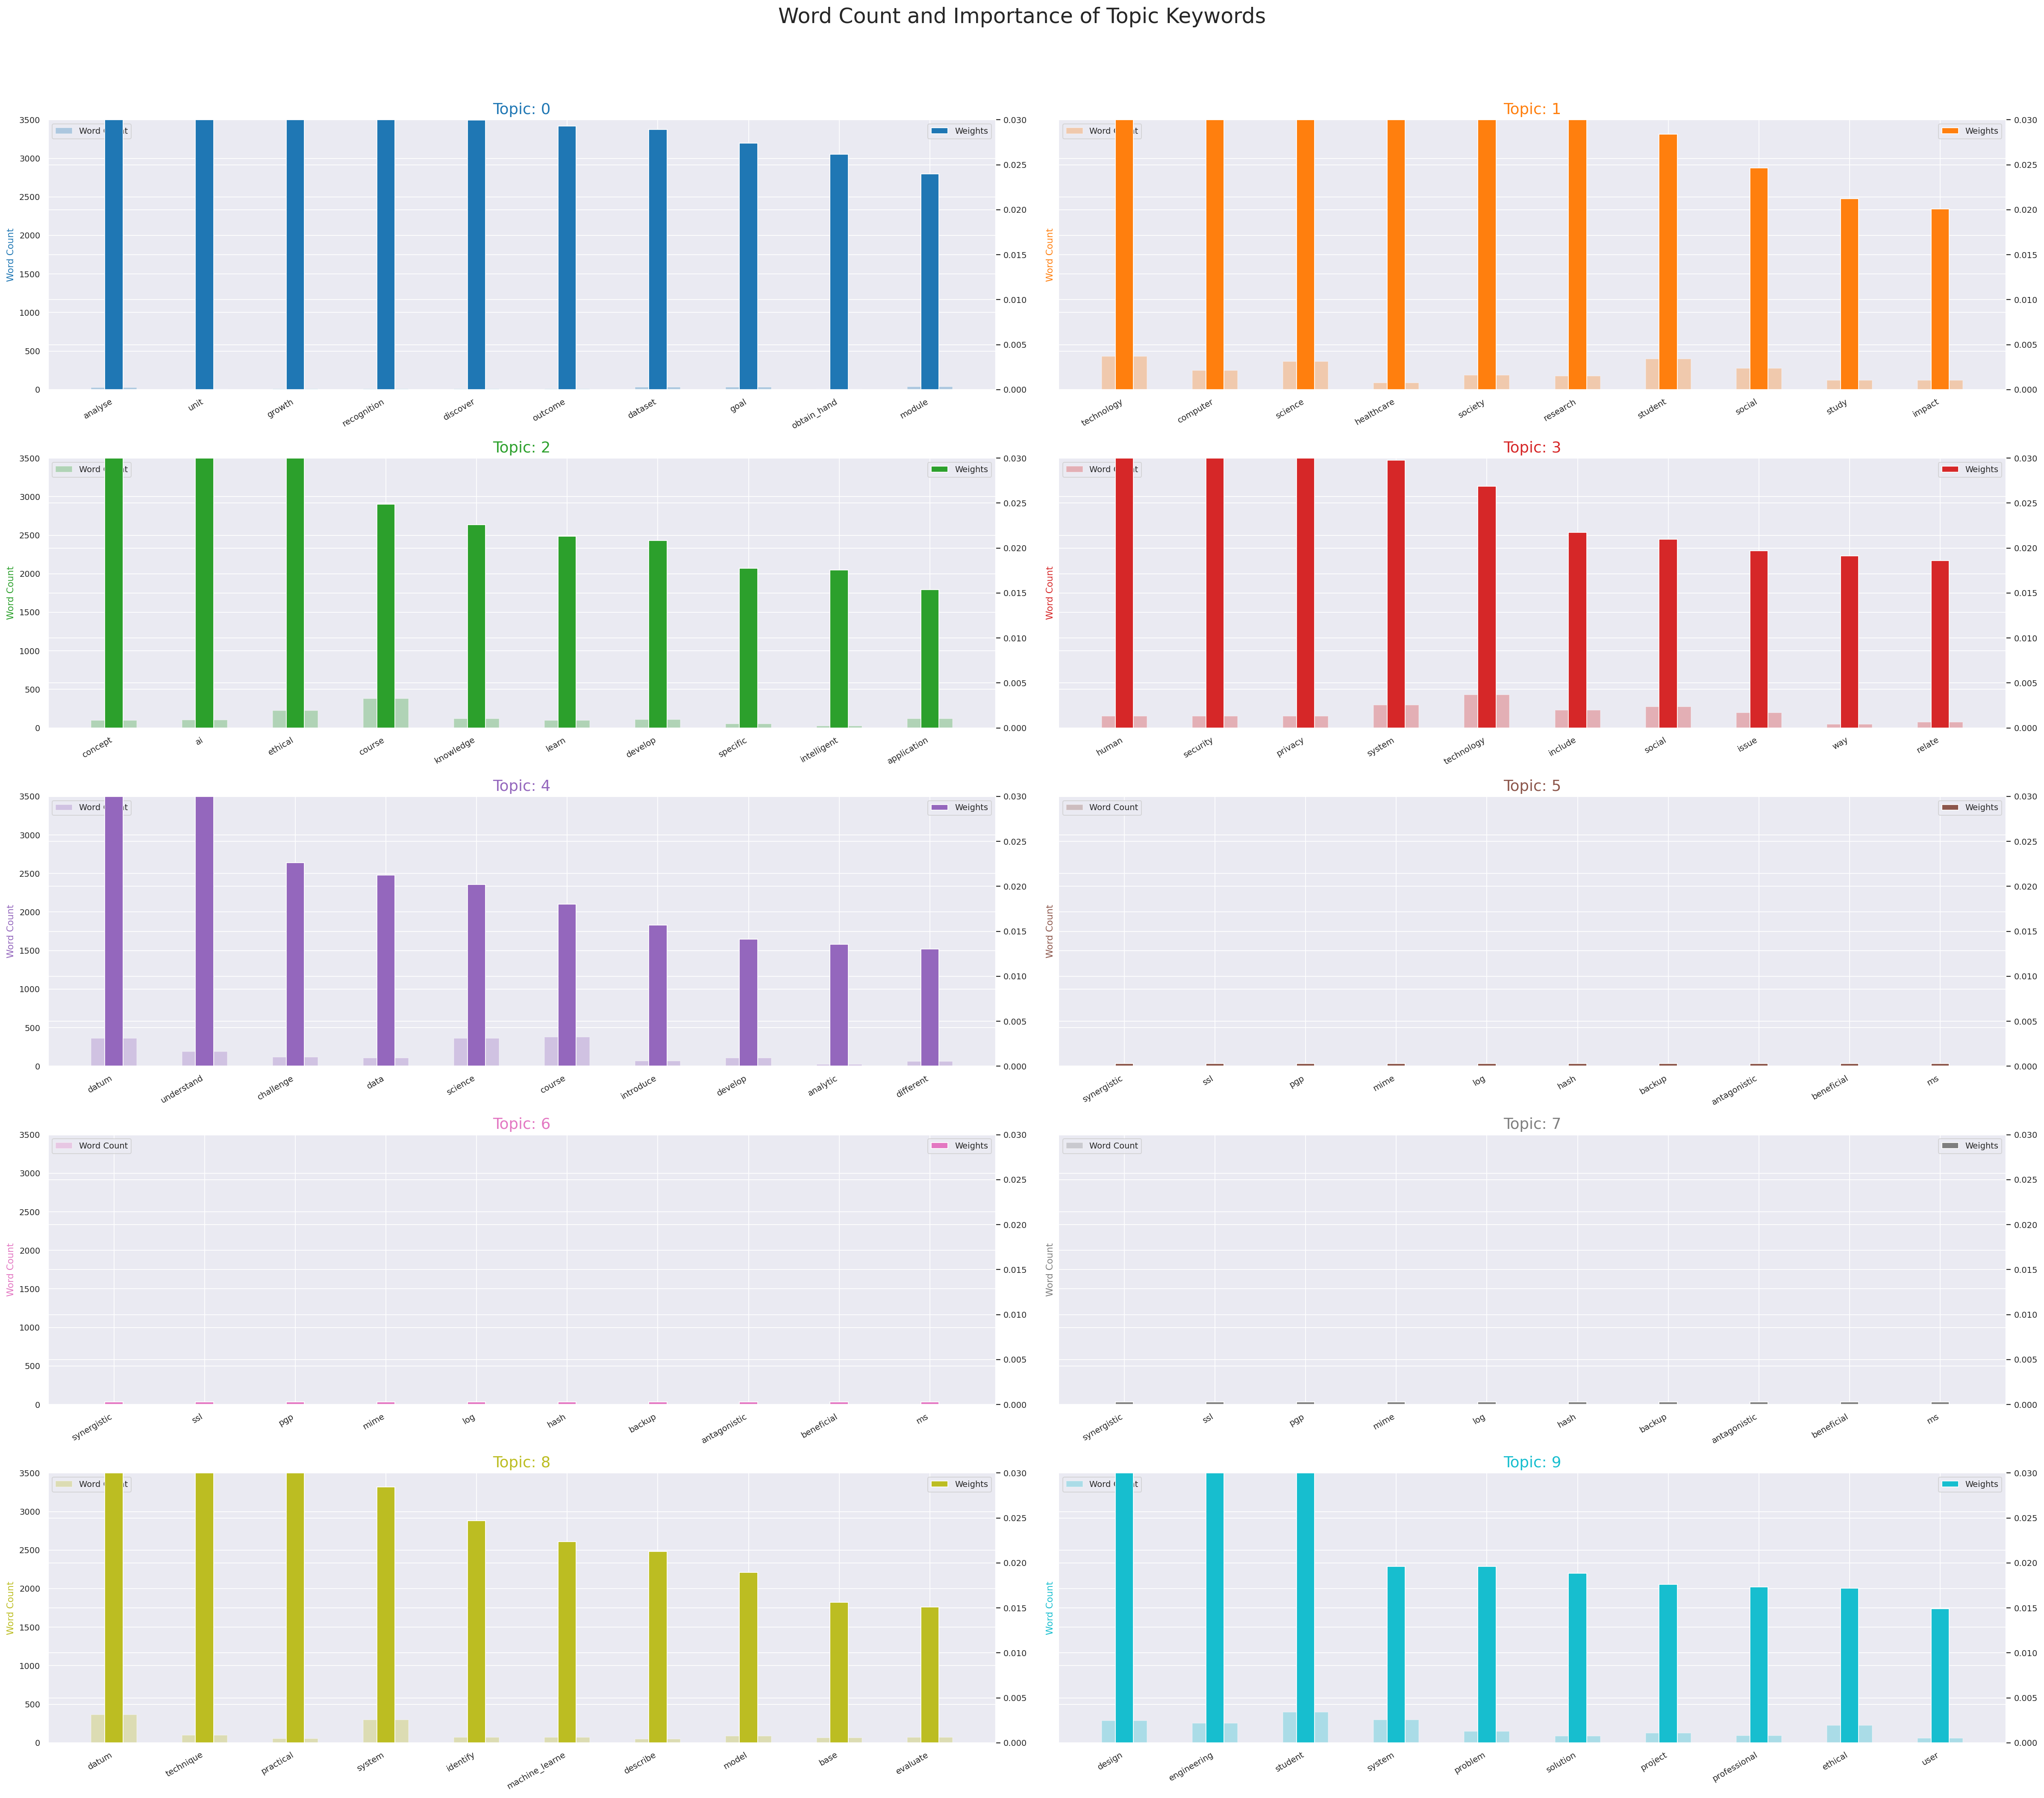

In [54]:
from collections import Counter
from matplotlib import colors as mcolors
topics = lda_model.show_topics(formatted=False)
data_flat = [w for w_list in data_ready for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(5, 2, figsize=(30,25), sharey=True, dpi=160)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax_twin.set_ylim(0, 0.030); ax.set_ylim(0, 3500)
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

fig.tight_layout(w_pad=2)    
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)    
plt.show()

## What are the most discussed topics in the documents?

In [55]:
# Sentence Coloring of N Sentences
def topics_per_document(model, corpus, start=0, end=1):
    corpus_sel = corpus[start:end]
    dominant_topics = []
    topic_percentages = []
    for i, corp in enumerate(corpus_sel):
        topic_percs, wordid_topics, wordid_phivalues = model[corp]
        dominant_topic = sorted(topic_percs, key = lambda x: x[1], reverse=True)[0][0]
        dominant_topics.append((i, dominant_topic))
        topic_percentages.append(topic_percs)
    return(dominant_topics, topic_percentages)

dominant_topics, topic_percentages = topics_per_document(model=lda_model, corpus=corpus, end=-1)            

# Distribution of Dominant Topics in Each Document
df = pd.DataFrame(dominant_topics, columns=['Document_Id', 'Dominant_Topic'])
dominant_topic_in_each_doc = df.groupby('Dominant_Topic').size()
df_dominant_topic_in_each_doc = dominant_topic_in_each_doc.to_frame(name='count').reset_index()

# Total Topic Distribution by actual weight
topic_weightage_by_doc = pd.DataFrame([dict(t) for t in topic_percentages])
df_topic_weightage_by_doc = topic_weightage_by_doc.sum().to_frame(name='count').reset_index()

# Top 3 Keywords for each Topic
topic_top3words = [(i, topic) for i, topics in lda_model.show_topics(formatted=False) 
                                 for j, (topic, wt) in enumerate(topics) if j < 3]

df_top3words_stacked = pd.DataFrame(topic_top3words, columns=['topic_id', 'words'])
df_top3words = df_top3words_stacked.groupby('topic_id').agg(', \n'.join)
df_top3words.reset_index(level=0,inplace=True)

##### 1- The number of documents for each topic by assigning the document to the topic that has the most weight in that document.
#### 2- The number of documents for each topic by by summing up the actual weight contribution of each topic to respective documents.

In [56]:
import seaborn as sns
sns.set_style('darkgrid')
sns.set_context('talk')

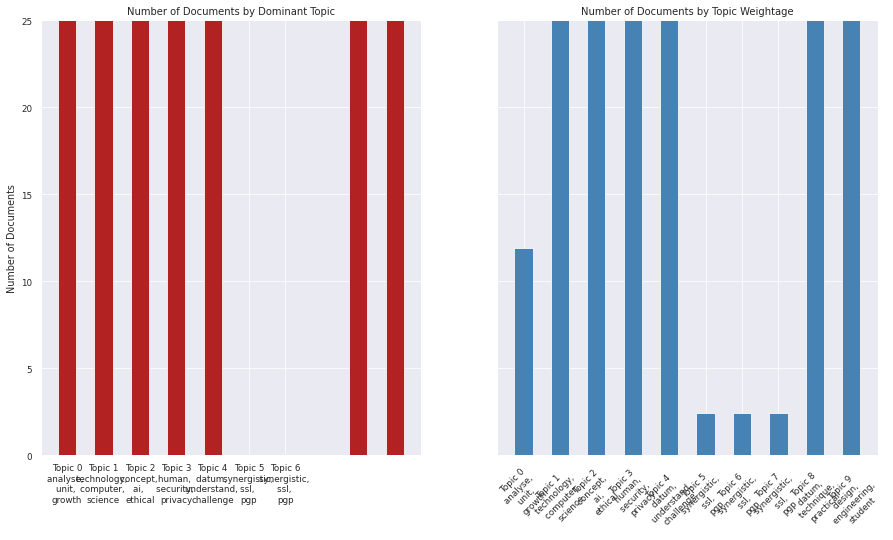

In [62]:
from matplotlib.ticker import FuncFormatter

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 8),sharey=True)

# Topic Distribution by Dominant Topics
ax1.bar(x='Dominant_Topic', height='count', data=df_dominant_topic_in_each_doc, width=.5, color='firebrick')
ax1.set_xticks(range(df_dominant_topic_in_each_doc.Dominant_Topic.unique().__len__()))
tick_formatter = FuncFormatter(lambda x, pos: 'Topic ' + str(x)+ '\n' + df_top3words.loc[df_top3words.topic_id==x, 'words'].values[0])
ax1.xaxis.set_major_formatter(tick_formatter)
ax1.set_title('Number of Documents by Dominant Topic', fontdict=dict(size=10))
ax1.set_ylabel('Number of Documents')
ax1.set_ylim(0, 25)
plt.xticks(rotation=45)

# Topic Distribution by Topic Weights
ax2.bar(x='index', height='count', data=df_topic_weightage_by_doc, width=.5, color='steelblue')
ax2.set_xticks(range(df_topic_weightage_by_doc.index.unique().__len__()))
ax2.xaxis.set_major_formatter(tick_formatter)
ax2.set_title('Number of Documents by Topic Weightage', fontdict=dict(size=10))

plt.xticks(rotation=45)
plt.show()

## t-SNE Clustering Chart

In [65]:
# Get topic weights and dominant topics ------------
from sklearn.manifold import TSNE
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook

# Get topic weights
topic_weights = []
for i, row_list in enumerate(lda_model[corpus]):
    topic_weights.append([w for i, w in row_list[0]])

# Array of topic weights    
arr = pd.DataFrame(topic_weights).fillna(0).values

# Keep the well separated points (optional)
arr = arr[np.amax(arr, axis=1) > 0.35]

# Dominant topic number in each doc
topic_num = np.argmax(arr, axis=1)

# tSNE Dimension Reduction
tsne_model = TSNE(n_components=2, verbose=1, random_state=0, angle=.99, init='pca')
tsne_lda = tsne_model.fit_transform(arr)

# Plot the Topic Clusters using Bokeh
output_notebook()
n_topics = 10
mycolors = np.array([color for name, color in mcolors.TABLEAU_COLORS.items()])
plot = figure(title="t-SNE Clustering of {} LDA Topics".format(n_topics), 
              plot_width=900, plot_height=700)
plot.scatter(x=tsne_lda[:,0], y=tsne_lda[:,1], color=mycolors[topic_num])
show(plot)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 352 samples in 0.000s...
[t-SNE] Computed neighbors for 352 samples in 0.004s...
[t-SNE] Computed conditional probabilities for sample 352 / 352
[t-SNE] Mean sigma: 0.160639
[t-SNE] KL divergence after 250 iterations with early exaggeration: 61.712749
[t-SNE] KL divergence after 1000 iterations: 0.435516


Loading BokehJS ...